In [14]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [1]:
!pip install torch==1.7.0+cu110 torchvision==0.8.1+cu110 torchaudio===0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu110/torch-1.7.0%2Bcu110-cp38-cp38-win_amd64.whl (2046.8 MB)
  Using cached https://download.pytorch.org/whl/cu110/torchvision-0.8.1%2Bcu110-cp38-cp38-win_amd64.whl (1.6 MB)
  Using cached https://download.pytorch.org/whl/torchaudio-0.7.0-cp38-none-win_amd64.whl (103 kB)
  Using cached dataclasses-0.6-py3-none-any.whl (14 kB)
  Attempting uninstall: torch
    Found existing installation: torch 1.8.1
    Uninstalling torch-1.8.1:
      Successfully uninstalled torch-1.8.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.9.1
    Uninstalling torchvision-0.9.1:
      Successfully uninstalled torchvision-0.9.1


### Построение нейросети, распознающей рукописные цифры

### Построение нейросети

In [1]:
import numpy as np
import torch
import seaborn as sns
from matplotlib import pyplot as plt

# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import pandas as pd

In [2]:
torch.manual_seed(1)
np.random.seed(1)

In [3]:
import random
random.seed(0)

In [4]:
train = torch.load('./data/train.pt')
test = torch.load('./data/test.pt')
valid = torch.load('./data/valid.pt')

In [5]:
batch_size = 1000
train_loader = DataLoader(dataset=train, batch_size=1000, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=1000, shuffle=False)
valid_loader = DataLoader(dataset=valid, batch_size=1000, shuffle=False)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
class ConvNet(nn.Module):
    def __init__(self):

        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
             nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
             nn.ReLU(),
             nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
             nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
             nn.ReLU(),
             nn.MaxPool2d(kernel_size=2, stride=2))
        self.bn1 = nn.BatchNorm1d(7 * 7 * 64)
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.relu1 = nn.ReLU()
        
        self.drop_out2 = nn.Dropout(0.1)
        self.bn2 = nn.BatchNorm1d(1000)
        self.fc2 = nn.Linear(1000, 500)
        self.relu2 = nn.ReLU()
        
        self.drop_out3 = nn.Dropout(0.2)
        self.bn3 = nn.BatchNorm1d(500)
        self.fc3 = nn.Linear(500, 10)
        #в архитектуре на выходе нет софтмакса, так как он вычисляет внутри nn.CrossEntropyLoss()
        #и учитывается во время подсчета accuracy
      
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.bn1(out)
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.drop_out2(out)
        out = self.bn2(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.drop_out3(out)
        out = self.bn3(out)
        out = self.fc3(out)
        return out

In [41]:
num_epochs = 200
num_classes = 10
learning_rate = 1e-3

In [42]:
from  torch.optim.lr_scheduler import StepLR

In [57]:
model = ConvNet()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=10, gamma=0.7)

In [58]:
%%time
# Train the model
total_step = len(train_loader)
train_losses = []
test_losses = []
eps = 3e-4
eps_counter = 0
EPS_BORDER = 3
for epoch in range(num_epochs):
    train_loss = []
    for i, (images, labels) in enumerate(train_loader):
        images.size()
        # Run the forward pass
        images = images.float().to(device)
        labels = labels.to(device)
        outputs = model(images.unsqueeze(1))
        loss = criterion(outputs, labels)
        train_loss.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    with torch.no_grad():
        images = test.tensors[0].float().to(device)
        labels = test.tensors[1].to(device)
        output = model(images.unsqueeze(1))  
        loss = criterion(output, labels)
        test_losses.append(loss.cpu().detach().numpy())
            
    train_losses.append(np.mean(train_loss)) 
    print('Epoch [{}/{}], Train Loss(mean): {:.4f}, Test Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, np.mean(train_loss),
                          test_losses[epoch]))
    #early stopper
    if len(test_losses) >= 2 and np.abs(test_losses[-1] - test_losses[-2]) < eps:
        eps_counter = eps_counter + 1
    else:
        eps_counter = 0
    if eps_counter >= EPS_BORDER:
        break
print('Finished')

Epoch [1/200], Train Loss(mean): 0.1764, Test Loss: 0.0557
Epoch [2/200], Train Loss(mean): 0.0436, Test Loss: 0.0461
Epoch [3/200], Train Loss(mean): 0.0362, Test Loss: 0.0448
Epoch [4/200], Train Loss(mean): 0.0342, Test Loss: 0.0445
Epoch [5/200], Train Loss(mean): 0.0344, Test Loss: 0.0447
Epoch [6/200], Train Loss(mean): 0.0343, Test Loss: 0.0447
Epoch [7/200], Train Loss(mean): 0.0339, Test Loss: 0.0442
Epoch [8/200], Train Loss(mean): 0.0343, Test Loss: 0.0439
Epoch [9/200], Train Loss(mean): 0.0344, Test Loss: 0.0448
Epoch [10/200], Train Loss(mean): 0.0339, Test Loss: 0.0433
Epoch [11/200], Train Loss(mean): 0.0345, Test Loss: 0.0449
Epoch [12/200], Train Loss(mean): 0.0338, Test Loss: 0.0438
Epoch [13/200], Train Loss(mean): 0.0342, Test Loss: 0.0438
Epoch [14/200], Train Loss(mean): 0.0346, Test Loss: 0.0439
Epoch [15/200], Train Loss(mean): 0.0338, Test Loss: 0.0454
Epoch [16/200], Train Loss(mean): 0.0342, Test Loss: 0.0440
Epoch [17/200], Train Loss(mean): 0.0338, Test Lo

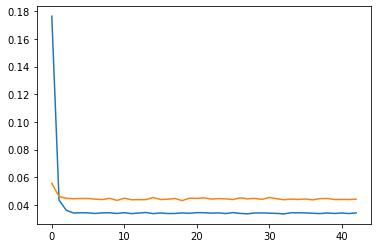

In [59]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.show()

### Отложенная выборка

In [60]:
model.eval()
with torch.no_grad():
    images = valid.tensors[0].float().to(device)
    labels = valid.tensors[1].to(device)
    output = model(images.unsqueeze(1))  
    loss = criterion(output, labels)
    print('Final validation Loss {}'.format(loss))

Final validation Loss 0.041859667748212814


In [61]:
valid_acc = torch.sum(torch.argmax(nn.functional.softmax(output, dim=1), dim=1) == labels) / valid.tensors[0].size()[0]

In [62]:
print('Final validation Accuracy {} %'.format(valid_acc*100))

Final validation Accuracy 98.7699966430664 %


### Сохранение модели

In [63]:
torch.save(model, 'mnist-cnn-model.pth')

In [64]:
model

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (bn1): BatchNorm1d(3136, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (relu1): ReLU()
  (drop_out2): Dropout(p=0.1, inplace=False)
  (bn2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=1000, out_features=500, bias=True)
  (relu2): ReLU()
  (drop_out3): Dropout(p=0.2, inplace=False)
  (bn3): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=500, out_features=10, bias=True)
